# Chapter 5 Exercises

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Simulate an AR(2) Process and Make Forecasts

#### Simulate a stationary AR(2) process. Use the `ArmaProcess` function from the `statsmodels` library and simulate this process:

$$
y_t = 0.33 y_{t-1} + 0.50 y_{t-2}
$$

#### 1. For this exercise, generate 1,000 samples.

```python
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])          # MA part: no moving average
ar2 = np.array([1, -0.33, -0.50])  # AR part: coefficients for AR(2)

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)


In [4]:
np.random.seed(42)                 # Set random seed for reproducibility

ma2 = np.array([1, 0, 0])          # MA part: no moving average
ar2 = np.array([1, -0.33, -0.50])  # AR part: coefficients for AR(2)

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)  # Generate the AR(2) process sample

#### 2. Plot your simulated autoregressive process.

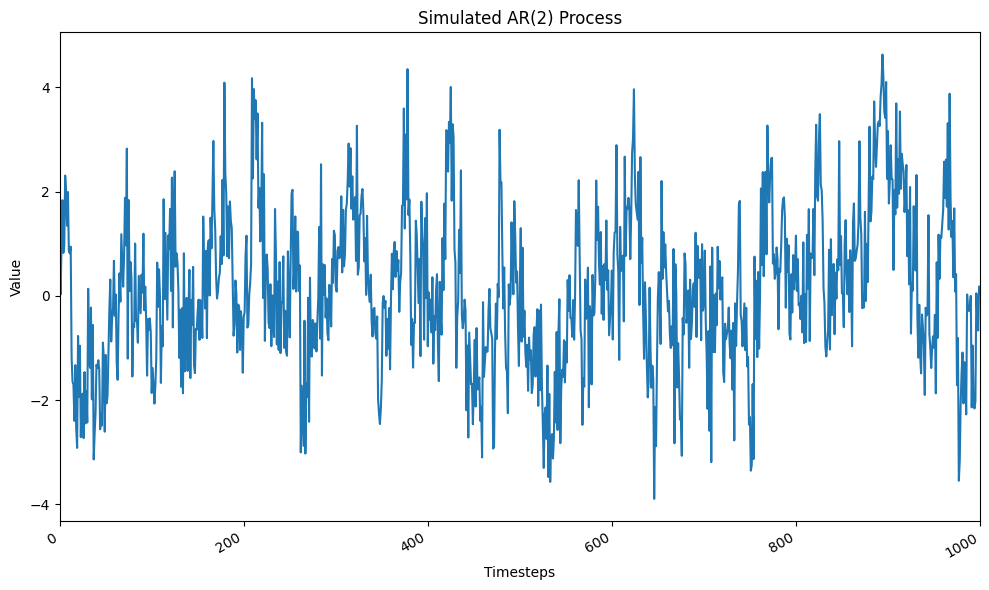

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(AR2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Simulated AR(2) Process')

ax.set_xlim(0, 1000) 

fig.autofmt_xdate()
plt.tight_layout()

#### 3. Run the ADF test and check if the process is stationary. If not, apply differencing.

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(AR2_process)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -7.566606021416909
p-value: 2.9145161293762334e-11

p-value < alpha; Ha: Stationary


#### 4. Plot the ACF. Is it slowly decaying?

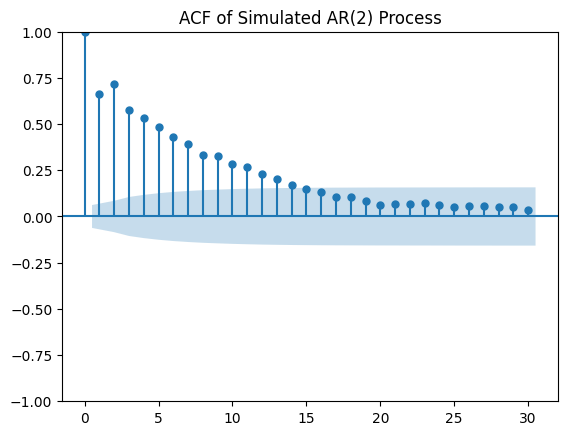

In [10]:
# Plot Auto Correlation Function
plot_acf(AR2_process, lags=30);

plt.title('ACF of Simulated AR(2) Process')

plt.show()

*YES*

#### 5. Plot the PACF. Are there significant coefficients after lag 2?

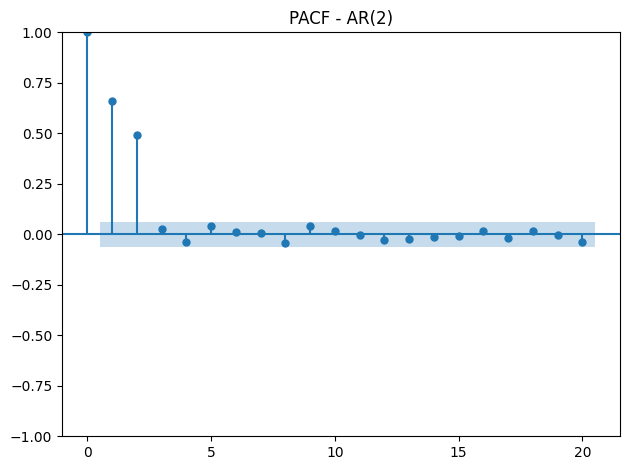

In [13]:
plot_pacf(AR2_process, lags=20);

plt.title('PACF - AR(2)')

plt.tight_layout()

*NO*

#### 6. Separate your simulated series into train and test sets. Take the first 800 timesteps for the train set and assign the rest to the test set.

In [16]:
df = pd.DataFrame({'value': AR2_process})

train = df[:800]
test = df[800:]

print(len(train))
print(len(test))

800
200


#### 7. Make forecasts over the test set. Use the historical mean method, last known value method, and an AR(2) model. Use the rolling_forecast function, and use a window length of 2.

In [18]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))    # <===== AR(2) model
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [19]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2  # <==== Since we wish to predict 2 timestep2, our window is 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.208203
801,0.095529,-0.049737,0.461912,0.289199
802,0.704340,-0.048056,0.095529,0.586307
803,-0.182079,-0.048056,0.095529,0.233598
804,-0.142412,-0.047287,-0.182079,0.281393


#### 8. Plot your forecasts.

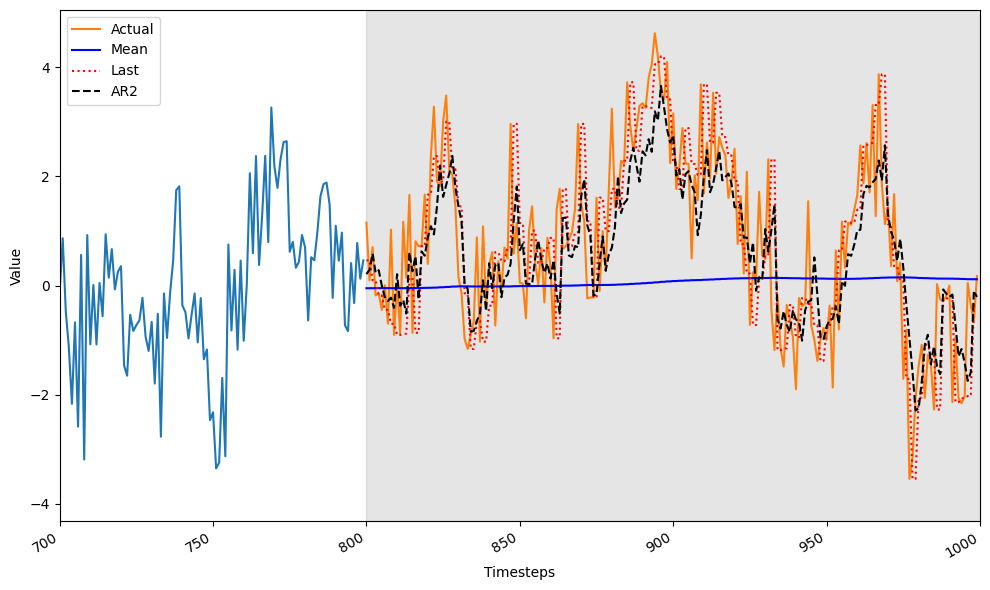

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_AR'], 'k--', label='AR2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

#### 9. Measure the MSE, and identify your champion model

In [23]:
from sklearn.metrics import mean_squared_error

# Calculate the MSE for each forecast
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_AR = mean_squared_error(test['value'], test['pred_AR'])

# Display MSE results
print(f'      MSE (Mean Forecast): {mse_mean:.2f}')
print(f'MSE (Last Value Forecast): {mse_last:.2f}')
print(f'     MSE (MA(2) Forecast): {mse_AR:.2f}')

      MSE (Mean Forecast): 3.09
MSE (Last Value Forecast): 1.21
     MSE (MA(2) Forecast): 0.97


*The AR(2) model achieves the lowest MSE and is therefore the champion model.*

#### 10. Plot your MSEs in a bar plot.

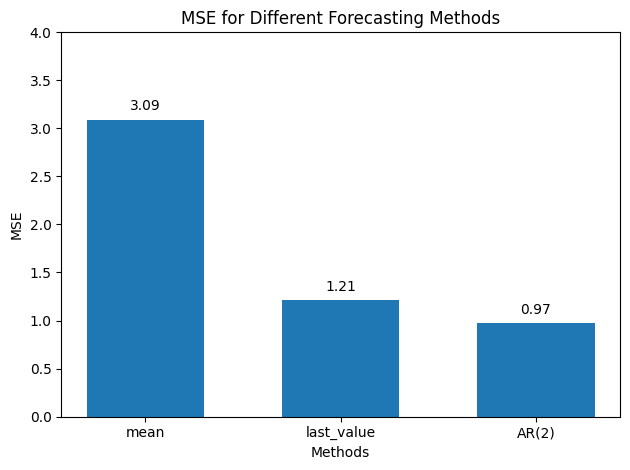

In [26]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

## Simulate an AR(p) process and make forecasts

#### Simulate a stationary AR(3) process.

$$
y_t = -0.33 * y_{t-1} -0.50 * y_{t-2} -0.07 * y_{t-3}
$$

In [29]:
np.random.seed(42)

ma3 = np.array([1, 0, 0, 0])
ar3 = np.array([1, -0.33, -0.50, -0.07])

AR3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)  # It will simulate the AR(3)

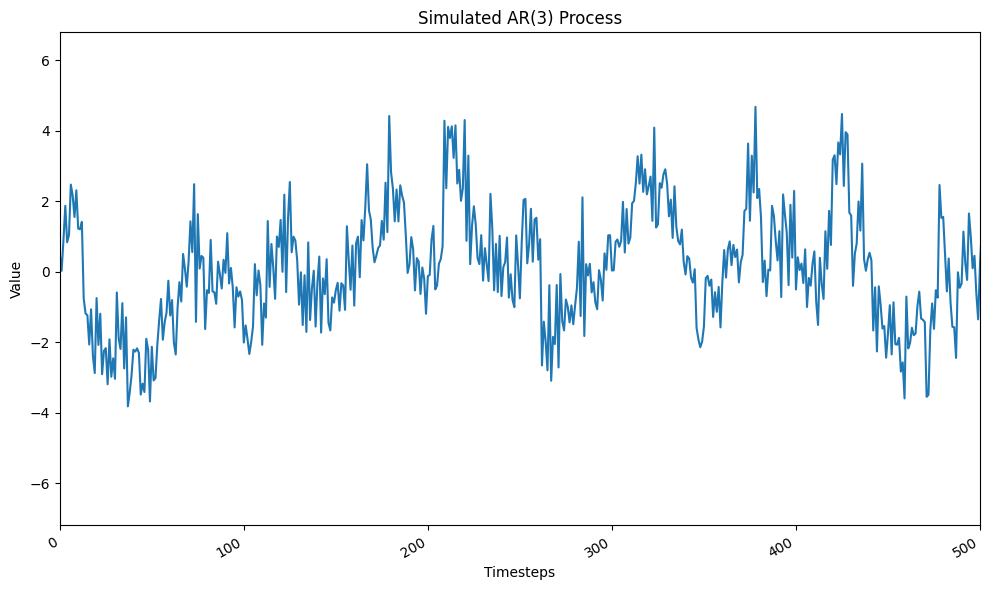

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(AR3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Simulated AR(3) Process')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result3 = adfuller(AR3_process)

# Display ADF test result
print(f"ADF Statistic: {adf_result3[0]}")
print(f"p-value: {adf_result3[1]}")
print()

if adf_result3[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -17.43229273521448
p-value: 4.759612221578498e-30

p-value < alpha; Ha: Stationary


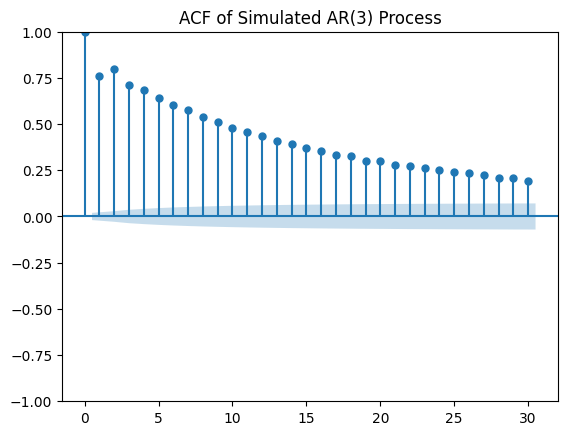

In [32]:
# Plot Auto Correlation Function
plot_acf(AR3_process, lags=30);

plt.title('ACF of Simulated AR(3) Process')

plt.show()

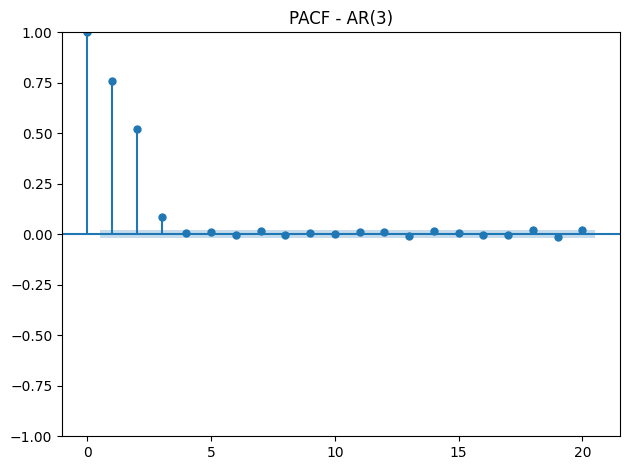

In [33]:
plot_pacf(AR3_process, lags=20);

plt.title('PACF - AR(3)')

plt.tight_layout()

In [34]:
AR3_df = pd.DataFrame({'value': AR3_process})

AR3_train = AR3_df[:-200]
AR3_test = AR3_df[-200:]

print(len(AR3_train))
print(len(AR3_test))

9800
200


In [35]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))       # <===== AR(3) model
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [36]:
TRAIN_LEN = len(AR3_train)
HORIZON = len(AR3_test)
WINDOW = 2   # <==== Since we wish to predict 2 timestep2, our window is 2

pred_mean = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

AR3_test['pred_mean'] = pred_mean
AR3_test['pred_last_value'] = pred_last_value
AR3_test['pred_AR'] = pred_AR

AR3_test.head()

,value,pred_mean,pred_last_value,pred_AR
9800,0.251942,-0.019215,-1.360546,-0.654957
9801,-0.127163,-0.019215,-1.360546,-0.918610
9802,2.294406,-0.019199,-0.127163,-0.037953
9803,-0.304373,-0.019199,-0.127163,-0.051933
9804,1.860432,-0.018992,-0.304373,1.024416


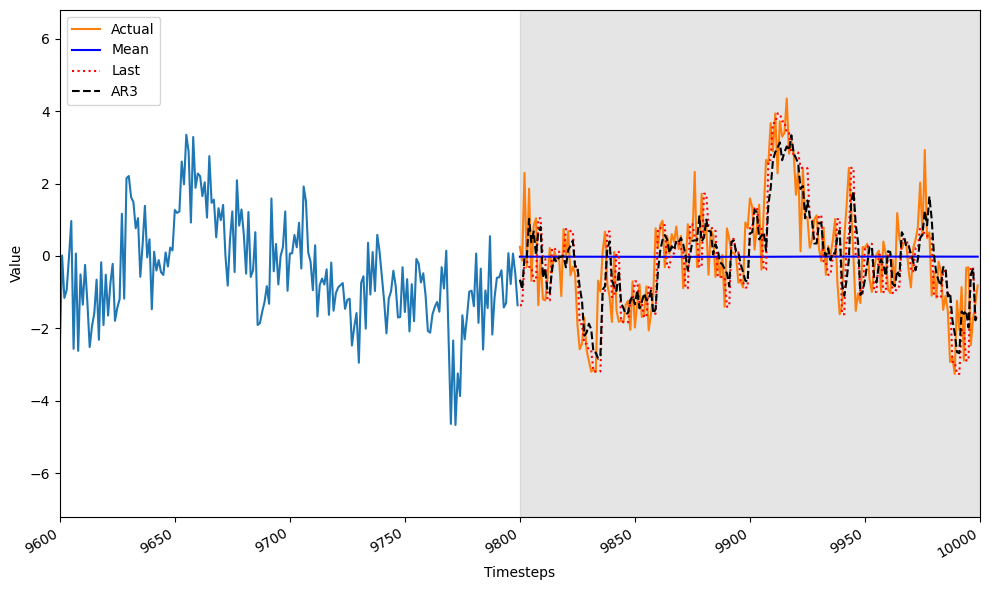

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(AR3_train)
ax.plot(AR3_test['value'], label='Actual')
ax.plot(AR3_test['pred_mean'], 'b-', label='Mean')
ax.plot(AR3_test['pred_last_value'], 'r:', label='Last')
ax.plot(AR3_test['pred_AR'], 'k--', label='AR3')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

plt.xlim(9600, 10000)
fig.autofmt_xdate()
plt.tight_layout()

In [38]:
# Calculate the MSE for each forecast
mse_mean3 = mean_squared_error(AR3_test['value'], AR3_test['pred_mean'])
mse_last3 = mean_squared_error(AR3_test['value'], AR3_test['pred_last_value'])
mse_AR3 = mean_squared_error(AR3_test['value'], AR3_test['pred_AR'])

# Display MSE results
print(f'      MSE (Mean Forecast): {mse_mean3:.2f}')
print(f'MSE (Last Value Forecast): {mse_last3:.2f}')
print(f'     MSE (MA(2) Forecast): {mse_AR3:.2f}')

      MSE (Mean Forecast): 2.14
MSE (Last Value Forecast): 1.29
     MSE (MA(2) Forecast): 1.00


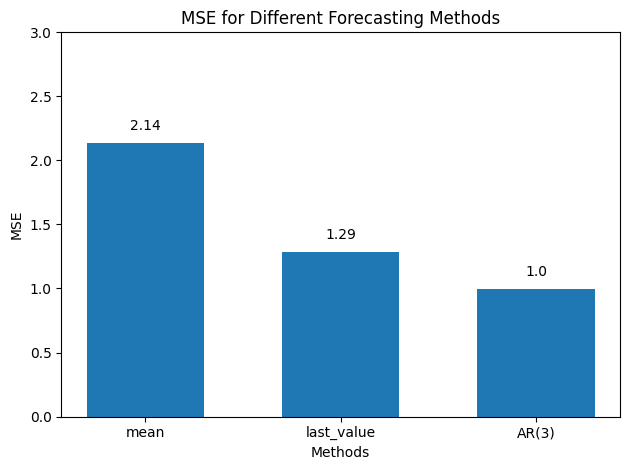

In [39]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean3, mse_last3, mse_AR3]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()